# Arbol de decision
En este notebook vamos a entrenar y explorar un arbol de decision.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, tree
from ipywidgets import Button, IntSlider, interactive

from preprocessing import cargarDatasets
from preprocessing import prepararSetDeEntrenamiento
from preprocessing import prepararSetDeValidacion
from preprocessing import ingenieriaDeFeauturesArboles1

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split,GridSearchCV

## Carga y preprocesamiento de los datos
Cargamos los datasets y los preparamos para usar.

In [2]:
train_df,final_df = cargarDatasets()
train_df = prepararSetDeEntrenamiento(train_df)
final_df = prepararSetDeValidacion(final_df)

In [3]:
X,y,df,y_encoder = ingenieriaDeFeauturesArboles1(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

In [4]:
X_train.head()

,ganancia_perdida_declarada_bolsa_argentina,categoria_de_trabajo_empleadao_estatal,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,estado_marital_matrimonio_civil,...,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas,educacion_alcanzada_encoded
29580,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,5
7359,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,8
30739,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,7
23107,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
14357,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,7


* ingenieria de feautures (2 formas)
* dividimos cada set en 2.
* entrenamos (2 arboles)
* metricas

fit: ajusta el modelo al set de entrenamiento
predict: que agarre un ejemplo y haga una prediccion (predice la clase a la que pertenece)


hiperparametros: quiero encontrar el mejor modelo para este dataset. Son parametros que el modelo no aprende, hay que decirselos.
-> random state: quiero que si un valor es random, que sea reproducible. Que el modelo vuelva a dar lo mismo cada vez que lo corro (que sea determinista).
->split: cuantos feautures miro para ir dividiendo.

In [7]:
params1 = {
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(10, 30),
    "criterion": ["gini", "entropy"],
}

arbol_1 = tree.DecisionTreeClassifier()
gscv1 = GridSearchCV(
    arbol_1, params1, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

arbol_1.fit(X_train, y_train)
y_pred1 = arbol_1.predict(X_test)
accuracy_score(y_test, y_pred1) 

0.8504758980657047

In [8]:
print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")

Best score: 0.85486630256226
Best params {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 19}


## Metricas
Las metricas a utilizar son:
* AUC-ROC  
* Matriz de confusión  
* Accuracy  
* Precisión  
* Recall  

Observamos las metricas obtenidas de las predicciones con el set de prueba.

### Curva AUC ROC
Primero calculamos el score obtenido con la curva de AUC ROC.

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
display(fpr)
display(tpr)
display(thresholds)

array([0.       , 0.0776385, 1.       ])

array([0.        , 0.62372449, 1.        ])

array([2, 1, 0])

In [11]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

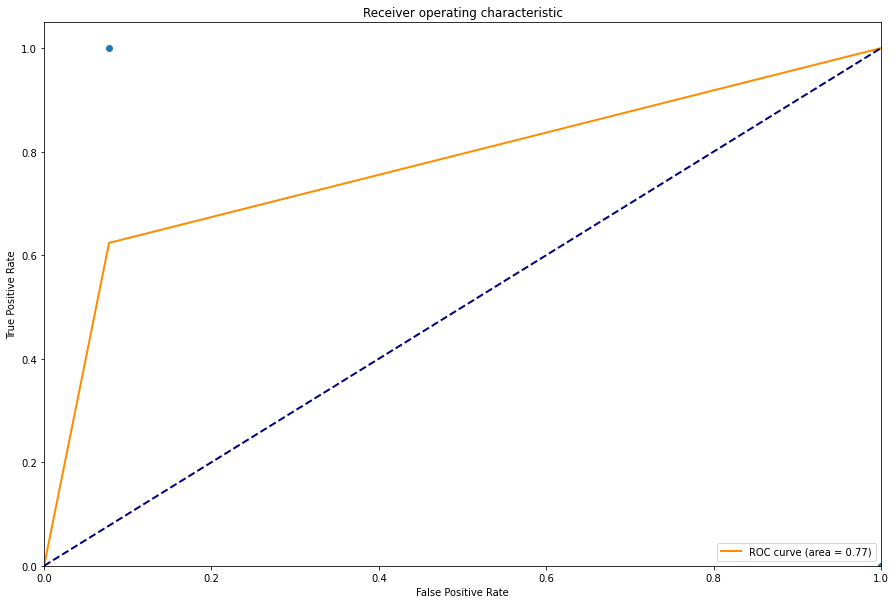

0.8786970712263877

In [12]:
plot_roc(fpr, tpr, thresholds)
roc_auc_score(y_test, arbol_1.predict_proba(X_test)[:,1])

**agregar conclusion (cuando entienda la curva)**

### Matriz de confusion

/home/sol/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


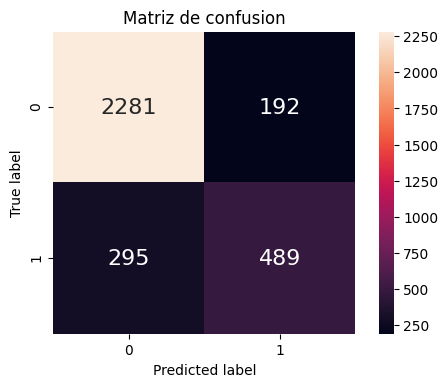

In [13]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, arbol_1.predict(X_test))

**no entiendo si deberia verse asi pero despues agregar conclusion**

### Accuracy
esta mas arriba, despues pasarlo aca y agregar conclusion

### Precision

In [14]:
precision_score(y_test, y_pred1)

0.7180616740088106

### Recall

In [42]:
recall_score(y_test, y_pred1)

0.6045918367346939